In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("data/job_description.csv")
df.head()

,Unnamed: 0,Category,Description,Benefits,Requirement,Requirements
0,0,Business Analyst,Description\nJob Title: Junior Business Analys...,Benefits\nMethods is passionate about its peop...,Requirements\n• Confidence in communicating an...,NaN
1,1,Business Analyst,Description\nThe Business Analyst (BA) will ca...,Benefits\nA competitive base salary\nBonus sch...,Requirements\nYou have…\nA methodical approach...,NaN
2,2,Business Analyst,Description\nWe help our clients design and de...,Benefits\nWe have 2 promotion windows open eac...,"Requirements\nYou are open, curious, and excit...",NaN
3,3,Business Analyst,Description\nFounded in 2015 and rapidly expan...,Benefits\nIn addition to a competitive package...,Requirements\nKey Responsibilities Include:\nP...,NaN
4,4,Business Analyst,Description\nWe are seeking a skilled Business...,Benefits\nFood Allowance\nGovernment Benefits\...,Requirements\nBachelor's Degree in management ...,NaN


In [5]:
df.describe()

,Unnamed: 0
count,325.000000
mean,162.000000
std,93.963645
min,0.000000
25%,81.000000
50%,162.000000
75%,243.000000
max,324.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    325 non-null    int64 
 1   Category      325 non-null    object
 2   Description   316 non-null    object
 3   Benefits      272 non-null    object
 4   Requirement   54 non-null     object
 5   Requirements  261 non-null    object
dtypes: int64(1), object(5)
memory usage: 15.4+ KB


In [7]:
df.isnull().sum()

Unnamed: 0        0
Category          0
Description       9
Benefits         53
Requirement     271
Requirements     64
dtype: int64

In [8]:
df.drop(columns=['Requirements', 'Requirement', 'Benefits', 'Unnamed: 0'], inplace=True)
df.dropna(inplace=True)

In [9]:
df.head()

,Category,Description
0,Business Analyst,Description\nJob Title: Junior Business Analys...
1,Business Analyst,Description\nThe Business Analyst (BA) will ca...
2,Business Analyst,Description\nWe help our clients design and de...
3,Business Analyst,Description\nFounded in 2015 and rapidly expan...
4,Business Analyst,Description\nWe are seeking a skilled Business...


In [10]:
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    return text

In [11]:
df["cleaned_text"] = df["Description"].apply(preprocess_text)

In [12]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

# Load SPLADE tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("naver/splade-cocondenser-ensembledistil")
model = AutoModelForMaskedLM.from_pretrained("naver/splade-cocondenser-ensembledistil")


In [13]:
def splade_encode(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)

    # Get sparse representation (logits -> ReLU to keep positive values)
    logits = outputs.logits.squeeze(0)
    sparse_vector = torch.nn.functional.relu(logits).sum(dim=0).cpu().numpy()
    return sparse_vector

# Example job descriptions
# job_texts = ["Data Scientist with Python and ML", "Software Engineer specializing in Java"]
# sparse_vectors = [splade_encode(text) for text in job_texts]
# print(sparse_vectors)

In [14]:
# Transform all text data using SPLADE
df["splade_vector"] = df["cleaned_text"].apply(splade_encode)

# Convert to NumPy array for SVM training
X = np.stack(df["splade_vector"].values)
y = df["Category"].values  # Assuming you have job categories

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
svm_model = SVC(kernel="linear", C=1.0, class_weight="balanced")
svm_model.fit(x_train, y_train)

SVC(class_weight='balanced', kernel='linear')

In [17]:
y_pred = svm_model.predict(x_test)

# Print evaluation metrics
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

  Business Analyst       0.73      1.00      0.85        11
             Cloud       0.71      0.56      0.62         9
    Data Scientist       1.00      0.90      0.95        21
                HR       0.50      0.50      0.50         4
Software Developer       0.78      0.78      0.78        18
             UI/UX       1.00      1.00      1.00         1

          accuracy                           0.81        64
         macro avg       0.79      0.79      0.78        64
      weighted avg       0.82      0.81      0.81        64



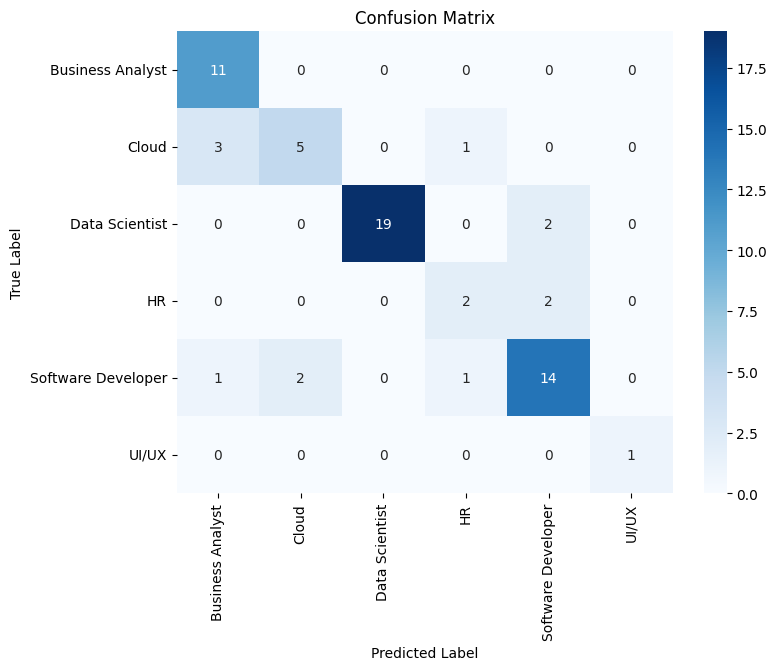

In [18]:
cm = confusion_matrix(y_test, y_pred)

class_labels = np.unique(y_test) 

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [25]:
from sklearn.metrics.pairwise import cosine_similarity


user_profile = input("Enter = ")
user_profile_cleaned = preprocess_text(user_profile)
user_vector = splade_encode(user_profile_cleaned)

similarity_scores = cosine_similarity([user_vector], X).flatten()

top_n = 10
top_indices = np.argsort(similarity_scores)[-top_n:][::-1]

recommendations = [
    {"Category": df.iloc[i]["Category"], "description": df.iloc[i]["Description"], "similarity": float(similarity_scores[i])}
        for i in top_indices
]

for i in recommendations:
    print(i)

{'Category': 'Data Scientist', 'description': 'Description\nGiskard defends the vision of a Responsible AI that serves the economic performance of companies while respecting the rights of citizens. To embody this mission, Giskard enables AI professionals (Data Scientists and Machine Learning Engineers) to evaluate & test the quality of ML models.\nWe are building the first collaborative & open-source Quality Assurance platform for *all* ML models. We already empower customers with two solutions:\n1. The Giskard Python library helps Data Scientists detect hidden vulnerabilities in ML models.\nIt makes the AI development process more efficient, by automating the identification of risks of biases, performance issues and errors.To try it, see this documentation.\n2. The Giskard Hub helps ML Engineers debug & monitor models, share dashboards, and collaborate\nIt makes the deployment of new ML models safer and more efficient, by providing ready-made monitoring dashboards, catalogs of re-usab